In [1]:
import warnings
warnings.filterwarnings('ignore')

### One to One

In [3]:
import numpy
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
  #t
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
  #t+1
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [5]:
numpy.random.seed(7)
# load the dataset
dataframe = pd.read_csv('AAPL.csv', index_col= 0)
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [6]:
dataset = dataframe[["Open"]]
dataset = dataset.values.astype('float32')

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
dataset.std()

22.796913

In [9]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
print(trainY[:5])

[0.         0.00029293 0.00730075 0.00709796 0.00799929]


In [13]:
print(testX[:5])
print(testY[:5])

[[0.22781047]
 [0.23055953]
 [0.22738233]
 [0.22959062]
 [0.23026657]]
[0.23055953 0.22738233 0.22959062 0.23026657 0.247527  ]


In [14]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back))) # 64, ...
model.add(Dense(1))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY,

validation_data=(testX, testY),
    epochs=100, 
    batch_size=128, # 32, 64, 128
    callbacks=[early_stopping],
)

Epoch 1/100
6/6 [==============================] - 7s 398ms/step - loss: 0.0192 - val_loss: 0.2149
Epoch 2/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0148 - val_loss: 0.1943
Epoch 3/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0111 - val_loss: 0.1750
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 0.0082 - val_loss: 0.1572
Epoch 5/100
6/6 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0.1410
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.0043 - val_loss: 0.1268
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0033 - val_loss: 0.1150
Epoch 8/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0028 - val_loss: 0.1059
Epoch 9/100
6/6 [==============================] - 0s 24ms/step - loss: 0.0025 - val_loss: 0.0994
Epoch 10/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0025 - val_loss: 0.0951
Epoch 11/100
6/6 [

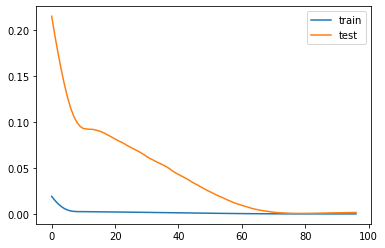

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainY[0][:5]

array([26.64249951, 26.67499903, 27.45249934, 27.43000031, 27.53000022])

In [21]:
trainPredict[:5]

array([[29.133343],
       [28.895287],
       [28.922419],
       [29.57265 ],
       [29.553804]], dtype=float32)

In [22]:
train_rmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f RMSE' % (train_rmse))
test_rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f RMSE' % (test_rmse))

Train RMSE: 0.99 RMSE
Test RMSE: 2.83 RMSE


In [23]:
train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f MAE' % (train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('test MAE: %.2f MAE' % (test_mae))

Train MAE: 0.79 MAE
test MAE: 2.23 MAE


##### Since the STD is around 22 and the MAE is less than 2.5, we would accept the model

In [24]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

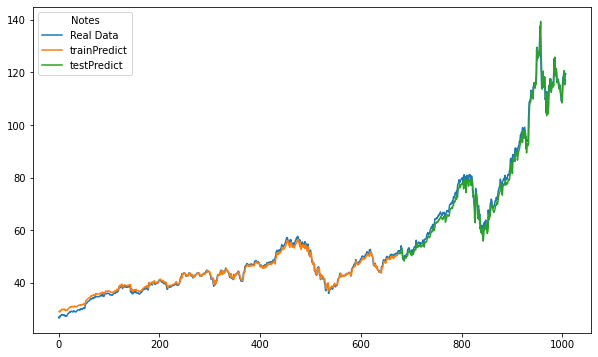

In [25]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset), label='Real Data')
plt.plot(trainPredictPlot, label='trainPredict')
plt.plot(testPredictPlot, label='testPredict')
plt.legend(title="Notes")
plt.show()

### Many to one

In [26]:
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder

In [27]:
dataset

array([[2.5687814e-03],
       [0.0000000e+00],
       [2.9292703e-04],
       ...,
       [8.1612933e-01],
       [8.3803153e-01],
       [8.3640921e-01]], dtype=float32)

In [28]:
dataset = pd.read_csv('AAPL.csv', index_col= 0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


In [30]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


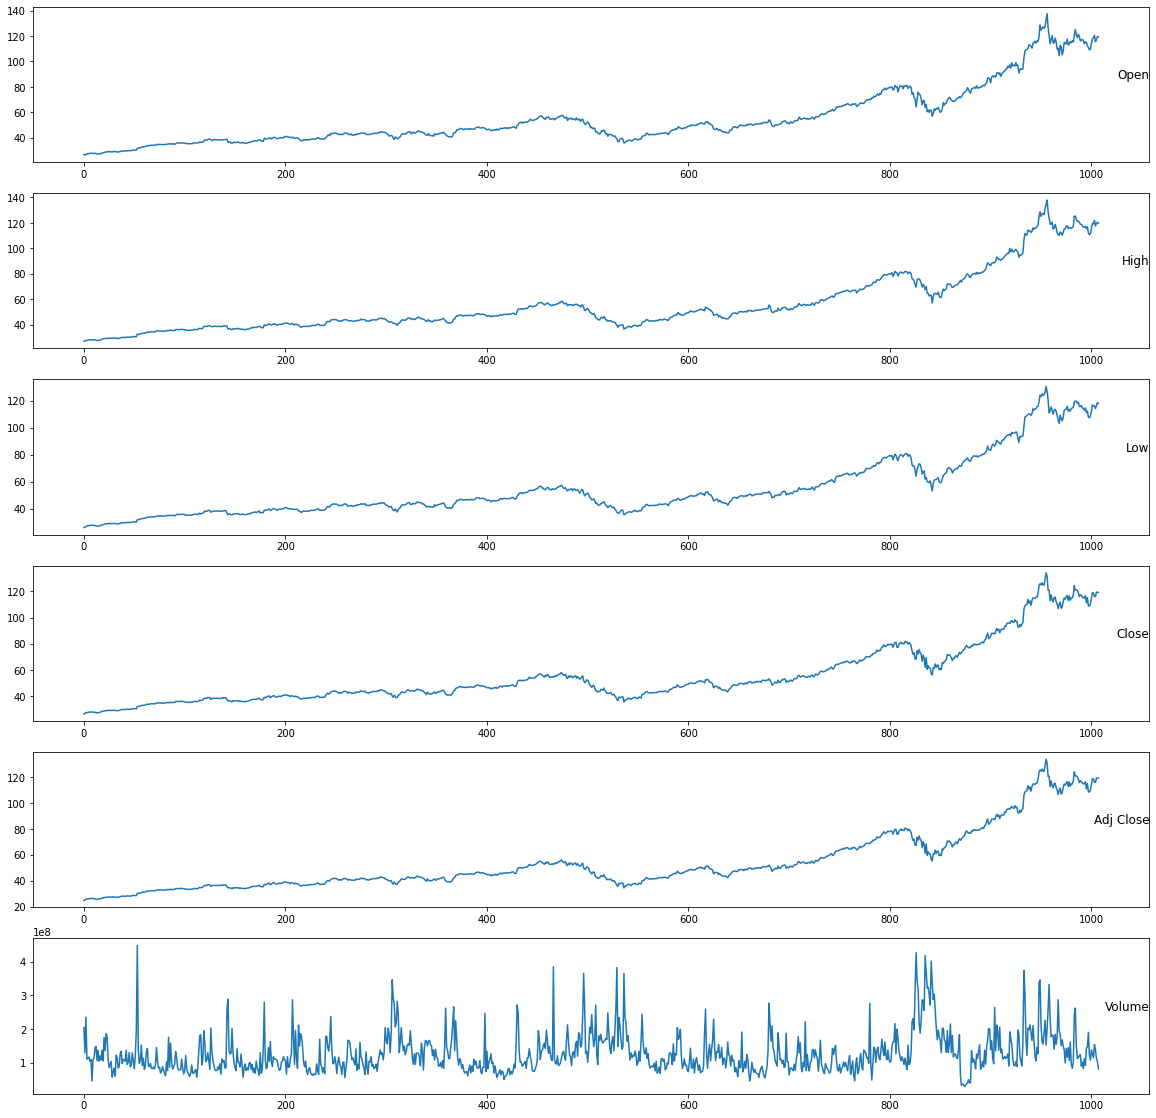

In [31]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5] # vì cột 4 là cột kiểu chuỗi
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [32]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))        
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
	return agg

In [33]:
# # load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
scaled = scaler.transform(values)
print("Frame as Series:")
print(scaled[:5])

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print("Frame as supervised learning:")
print(reframed.head())

print("Frame will use:")
print(reframed.head())

Frame as Series:
[[2.5687814e-03 2.9262900e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.1966838e-01]
 [0.0000000e+00 0.0000000e+00 4.9756020e-03 3.2481849e-03 3.0130148e-03
  2.3919241e-01]
 [2.9292703e-04 5.7401359e-03 6.0281307e-03 9.9301785e-03 9.2111528e-03
  4.9281877e-01]
 [7.3007494e-03 6.0102493e-03 1.1362538e-02 9.8373443e-03 9.1250390e-03
  1.9498245e-01]
 [7.0979595e-03 6.4379573e-03 1.3347998e-02 1.0092571e-02 9.3617886e-03
  2.0258759e-01]]
Frame as supervised learning:
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.002569   0.000293   0.000000   0.000000   0.000000   0.419668  0.000000   
2   0.000000   0.000000   0.004976   0.003248   0.003013   0.239192  0.000293   
3   0.000293   0.005740   0.006028   0.009930   0.009211   0.492819  0.007301   
4   0.007301   0.006010   0.011363   0.009837   0.009125   0.194982  0.007098   
5   0.007098   0.006438   0.013348   0.010093   0.009362   0.202588  0.007999   

    var2(t)   var3(t

In [34]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(dataset) * 0.67)
train = values[:n_train_hours, :]
# còn lại thì là test
test = values[n_train_hours:, :]
# split into input and outputs (các cột đầu, cột cuối)
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print("Before reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("After reshape:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Before reshape:
(675, 11) (675,) (332, 11) (332,)
After reshape:
(675, 1, 11) (675,) (332, 1, 11) (332,)


In [35]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]))) 
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,
      epochs=100,
      batch_size=72,
      validation_data=(test_X, test_y),
      verbose=2
      )

Epoch 1/100
10/10 - 3s - loss: 0.2076 - val_loss: 0.1621 - 3s/epoch - 309ms/step
Epoch 2/100
10/10 - 0s - loss: 0.1461 - val_loss: 0.1249 - 69ms/epoch - 7ms/step
Epoch 3/100
10/10 - 0s - loss: 0.1035 - val_loss: 0.1895 - 77ms/epoch - 8ms/step
Epoch 4/100
10/10 - 0s - loss: 0.0920 - val_loss: 0.2332 - 70ms/epoch - 7ms/step
Epoch 5/100
10/10 - 0s - loss: 0.0912 - val_loss: 0.2221 - 73ms/epoch - 7ms/step
Epoch 6/100
10/10 - 0s - loss: 0.0893 - val_loss: 0.1883 - 83ms/epoch - 8ms/step
Epoch 7/100
10/10 - 0s - loss: 0.0872 - val_loss: 0.1602 - 83ms/epoch - 8ms/step
Epoch 8/100
10/10 - 0s - loss: 0.0855 - val_loss: 0.1487 - 60ms/epoch - 6ms/step
Epoch 9/100
10/10 - 0s - loss: 0.0839 - val_loss: 0.1419 - 61ms/epoch - 6ms/step
Epoch 10/100
10/10 - 0s - loss: 0.0825 - val_loss: 0.1373 - 69ms/epoch - 7ms/step
Epoch 11/100
10/10 - 0s - loss: 0.0812 - val_loss: 0.1245 - 59ms/epoch - 6ms/step
Epoch 12/100
10/10 - 0s - loss: 0.0798 - val_loss: 0.1114 - 83ms/epoch - 8ms/step
Epoch 13/100
10/10 - 0s -

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,665
Trainable params: 5,665
Non-trainable params: 0
_________________________________________________________________


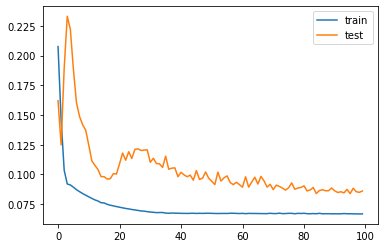

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### We can see that the One to One model above performs better than the Many to One model